In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from catboost import CatBoostClassifier
from tqdm.auto import tqdm
from sklearn.metrics import precision_recall_curve, roc_auc_score, average_precision_score

In [2]:
train = pd.read_pickle('../data/preprocessed/train.pkl')
test = pd.read_pickle('../data/preprocessed/test.pkl')

In [3]:
duplicated_cols = [
    'employee.AVG_TIME_BETWEEN(employee_history.date WHERE sick = 1)',
    'employee.COUNT(employee_history WHERE sick = 1)',
    'employee.MEDIAN(employee_history.home_to_work_distance)',
    'employee.MEDIAN(employee_history.home_to_work_duration)',
    'employee.MEDIAN(relatives_history.AGE(rel_birth))',
    'employee.MIN(employee_history.home_to_work_distance)',
    'employee.MIN(employee_history.home_to_work_duration)',
    'employee.MIN(relatives_history.AGE(rel_birth))',
    'employee.NUM_UNIQUE(relatives_history.YEAR(rel_birth))'
]
train = train.drop(duplicated_cols, axis=1)
test = test.drop(duplicated_cols, axis=1)

In [4]:
# скользящая валидация
folds = [
    train[train['date'] <= '2016-08-01'].copy(),
    train[(train['date'] > '2016-08-01') & (train['date'] <= '2017-08-01')].copy(),
    train[(train['date'] > '2017-08-01') & (train['date'] <= '2018-08-01')].copy(),
    train[(train['date'] > '2018-08-01') & (train['date'] <= '2019-08-01')].copy(),
]

In [6]:
cv_metrics = {
    'F1': [],
    'AP': [],
    'ROC-AUC': [],
    'threshold': [],
    'num_iterations': [],
}
for idx in tqdm(range(3), desc='Folds'):
    fold_train = pd.concat(folds[:idx + 1])
    fold_val = folds[idx + 1].copy()

    y_train = fold_train['sick']
    X_train = fold_train.drop(['date', 'cutoff_date', 'sick'], axis=1)
    y_val = fold_val['sick']
    X_val = fold_val.drop(['date', 'cutoff_date', 'sick'], axis=1)
    
    clf = CatBoostClassifier(iterations=3000, task_type='GPU', auto_class_weights='Balanced', od_pval=1e-6)
    cat_col_names = X_train.select_dtypes('category').columns.tolist()
    cat_features = [idx for idx, col in enumerate(X_train.columns) if col in cat_col_names]
    
    clf.fit(X_train, y_train, cat_features=cat_features, verbose=0, eval_set=(X_val, y_val), use_best_model=True)
    cv_metrics['num_iterations'].append(clf.tree_count_)
    y_probs = clf.predict_proba(X_val)[:, 1]
    
    ap = average_precision_score(y_val, y_probs)
    cv_metrics['AP'].append(ap)
    roc_auc = roc_auc_score(y_val, y_probs)
    cv_metrics['ROC-AUC'].append(roc_auc)
    
    p, r, thresholds = precision_recall_curve(y_val, y_probs)
    p = p[:-1]
    r = r[:-1]
    
    thresholds = thresholds[p > 0]
    r = r[p > 0]
    p = p[p > 0]
    f1_scores = 2 * r * p / (r + p)
    th = thresholds[np.argmax(f1_scores)]
    f1 = f1_scores.max()
    cv_metrics['F1'].append(f1)
    cv_metrics['threshold'].append(th)
    tqdm.write(f'Fold {idx}: F1 = {f1_scores.max():.4f} at th = {th:.4f}, AP = {ap:.4f}, ROC-AUC = {roc_auc:.4f}, trees: {clf.tree_count_}, lr = {clf.learning_rate_}')
print('Mean CV metrics:')
for key, lst in cv_metrics.items():
    print(f'{key} : {np.mean(lst)}')

Folds:   0%|          | 0/3 [00:00<?, ?it/s]

Fold 0: F1 = 0.2440 at th = 0.5017; AP = 0.1821, ROC-AUC = 0.6352, trees: 496, lr = 0.03509499877691269
Fold 1: F1 = 0.3006 at th = 0.5321; AP = 0.2279, ROC-AUC = 0.6745, trees: 182, lr = 0.032846998423337936
Fold 2: F1 = 0.3273 at th = 0.5987; AP = 0.2493, ROC-AUC = 0.6810, trees: 506, lr = 0.0315839983522892
Mean CV metrics:
F1 : 0.2906126345869451
AP : 0.21976594383836442
ROC-AUC : 0.663564111675211
threshold : 0.5441972916965199
num_iterations : 394.6666666666667


In [14]:
test.shape

(21021, 162)

In [7]:
# учим модель для скоринга теста
y_train = train['sick']
X_train = train.drop(['date', 'cutoff_date', 'sick'], axis=1)
X_test = test.drop(['date', 'cutoff_date'], axis=1)

clf = CatBoostClassifier(task_type='GPU', iterations=500, learning_rate=0.03, auto_class_weights='Balanced')
cat_col_names = X_train.select_dtypes('category').columns.tolist()
cat_features = [idx for idx, col in enumerate(X_train.columns) if col in cat_col_names]

clf.fit(X_train, y_train, cat_features=cat_features, verbose=100)
y_test = (clf.predict_proba(X_test)[:, 1] > 0.62).astype('int')

0:	learn: 0.6910069	total: 21.5ms	remaining: 10.8s
100:	learn: 0.6415661	total: 2.09s	remaining: 8.27s
200:	learn: 0.6320353	total: 4.16s	remaining: 6.19s
300:	learn: 0.6259410	total: 6.23s	remaining: 4.12s
400:	learn: 0.6211687	total: 8.27s	remaining: 2.04s
499:	learn: 0.6177556	total: 10.3s	remaining: 0us


In [8]:
sub = test[['hash_tab_num', 'date']].copy()
sub['target'] = y_test
sub.to_csv('../data/submissions/ft-ctb-cv-0.29.csv', index=False, sep=';')

In [9]:
import shap

In [10]:
explainer = shap.TreeExplainer(clf)

In [11]:
shap_values = explainer(X_test)

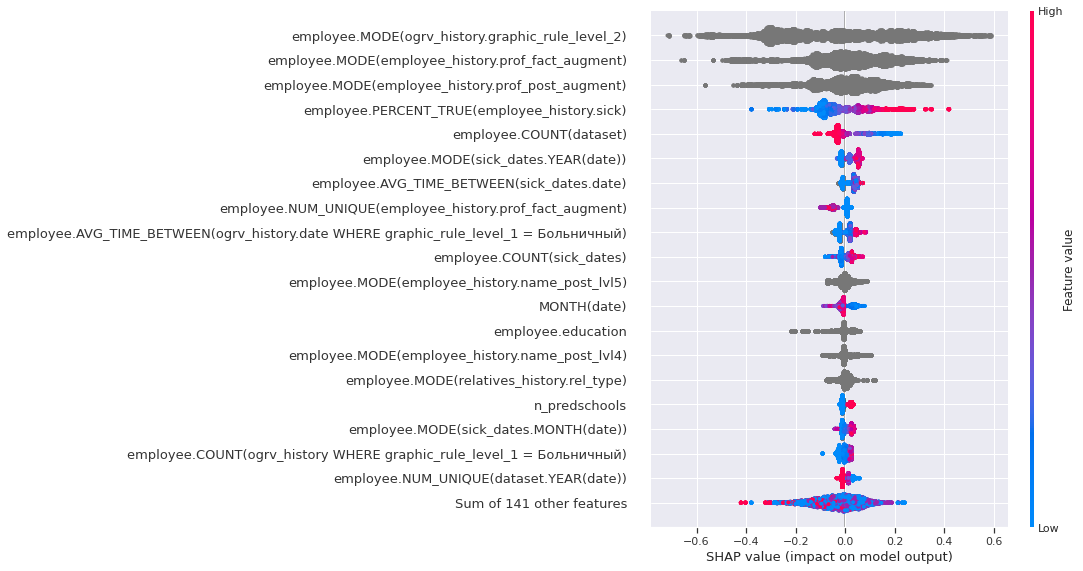

In [12]:
shap.plots.beeswarm(shap_values, max_display=20)